# <font color='darkblue'> Part 4 : Similarity Network Fusion with Graph Convolutional Networks</font> 

In the previous notebook we trained a Graph Convolutional Network on two similarity matrices. We found that when our network is bad, our performance is bad. When we have a more informative network we can improve this performance. 

Neither of our networks were more expressive than performing a basic linear regression however. We are not fully leveraging the power of neworks, in particular their flexibility. 

In this notebook we will use the Similarity Network Fusion (SNF) algorithm to integrate a second modality.

In this part we will : 
- Create a second patient similarity network 
- Train a quick GCN on this modality to test it's accuracy
- Perform SNF to integrate our two modalities
- Retrain a GCN on the combined network 

## <font color='darkblue'>Import Functions and Packages </font>

In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from palettable import wesanderson
import snf
import sys
sys.path.insert(0 , './../')
from functions import *
from sklearn.model_selection import train_test_split
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## <font color='darkblue'>Import and Process Generation Scotland Data</font>

In [2]:
with open('./../data/GCN_Data.pkl' , 'rb') as file : 
    loaded_data = pd.read_pickle(file)

phenotypes = loaded_data['phenotypes']

## <font color='darkblue'> Create Patient Similarity Network for Second Modality </font>

### NOTE : Creating temporary second modality of time since last cigarette. Waiting for more Gen Scot data. This will be artificially high

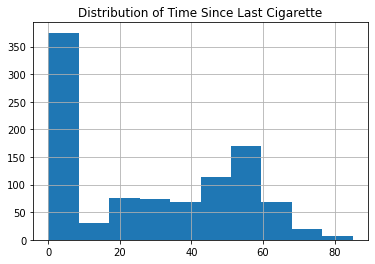

Non-Smoker : 0 
Smoker : 1


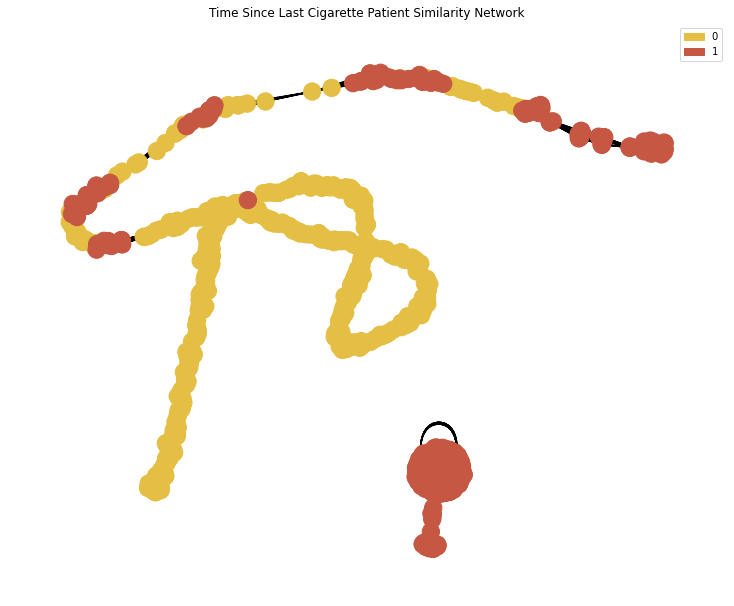

In [3]:
from sklearn.preprocessing import MinMaxScaler

def time_since_last_smoked(row) : 
    if row['pack_years'] == 0 : 
        return row['age']
    else :
        if row.isna()['stopped'] :
            return 0
        else : 
            return row['stopped']
        
phenotypes['time_since_last_smoked'] = phenotypes.apply(time_since_last_smoked , axis =1)

phenotypes['time_since_last_smoked'].hist()
plt.title('Distribution of Time Since Last Cigarette')
plt.show()

scaler = MinMaxScaler()
scaled_time = scaler.fit_transform(phenotypes[['time_since_last_smoked']]).reshape(1,-1)[0]

n = len(scaled_time)

# Create a DataFrame filled with zeros
df = pd.DataFrame(np.zeros((n, n)) , columns=phenotypes.index , index=phenotypes.index)

# Fill the DataFrame with the differences
for i, integer in enumerate(scaled_time):
    df.iloc[i, :] = 1 - np.abs(np.array(scaled_time) - integer)

node_colour = phenotypes['Smoking'].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

print(f"{phenotypes['Smoking'].astype('category').cat.categories[0]} : 0 \n{phenotypes['Smoking'].astype('category').cat.categories[1]} : 1")

G_time_to_smoke = plot_knn_network(df , 25 , phenotypes['Smoking'] , node_colours=node_colour)
plt.title('Time Since Last Cigarette Patient Similarity Network')
legend_handles = gen_graph_legend(node_colour , G_time_to_smoke , 'label')
plt.legend(handles = legend_handles)
plt.show()

## <font color='darkblue'> Train GCN on second modality for comparison of performance </font>

Here we will re-use the code from the previous section, specifically the train and evaluate functions. 

GCN(
  (gcnlayers): ModuleList(
    (0): GraphConv(in=23676, out=128, normalization=both, activation=None)
    (1): GraphConv(in=128, out=2, normalization=both, activation=None)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout(p=0.05, inplace=False)
)
Graph(num_nodes=1000, num_edges=34549,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int32), 'label': Scheme(shape=(), dtype=torch.int8), 'feat': Scheme(shape=(23676,), dtype=torch.float32)}
      edata_schemes={})


Loss :   0%|          | 0/1200 [00:00<?, ?epoch/s]

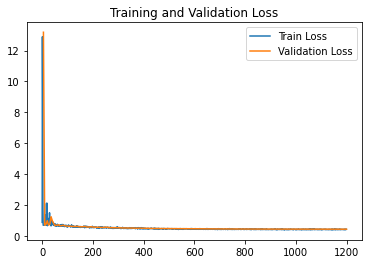

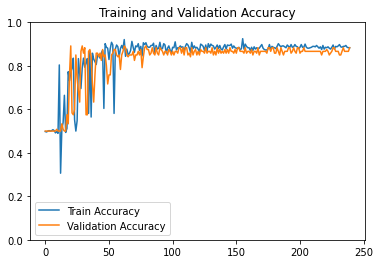

GNN Model | Test Accuracy = 0.8675 | F1 = 0.8425 |


In [4]:
g = dgl.from_networkx(G_time_to_smoke , node_attrs=['idx' , 'label']) # Convert networkx graph to dgl graph
g.ndata['feat'] = torch.Tensor(loaded_data['Feat'].iloc[g.ndata['idx'].numpy()].values) # Add node features to graph

device = ('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available

g = g.to(device) # Move graph to device

node_subjects = phenotypes['Smoking'].iloc[g.ndata['idx'].detach().cpu().numpy()].reset_index(drop=True) # Get node target labels from meta data
node_subjects.name = 'Smoking'

train_tmp_index , test_index = train_test_split(                 # Split data into temporary training and testing sets
    node_subjects.index, train_size=0.6, stratify=node_subjects
    )
train_index , val_index = train_test_split(                       # Split temporary training data into training and validation sets
    train_tmp_index, train_size=0.8, stratify=node_subjects.loc[train_tmp_index]
    )

GCN_input_shapes = g.ndata['feat'].shape[1] # Get input shape for GCN

labels = F.one_hot(g.ndata['label'].to(torch.int64)) #  One hot encode labels

output_metrics = []
logits = np.array([])
labels_all = np.array([])

model = GCN(GCN_input_shapes , [128], len(node_subjects.unique())).to(device)  # Create GCN model
print(model)
print(g)

loss_plot = train(g, g.ndata['feat'] , train_index , val_index , device ,  model , labels , 1200 , 1e-3) # Train model
plt.show()

test_output_metrics = evaluate(test_index , device , g , g.ndata['feat'] , model , labels ) # Evaluate model on test set

print(
    "GNN Model | Test Accuracy = {:.4f} | F1 = {:.4f} |".format(
     test_output_metrics[1] , test_output_metrics[2] )
)

## <font color='darkblue'> Similarity Network Fusion (SNF) </font>

We will once again implement SNF from the paper by [Wang et al.](https://www.nature.com/articles/nmeth.2810)

We will implement it using the python package [snfpy](https://pypi.org/project/snfpy/)

In [5]:
'''
#################################################
                YOUR CODE HERE
#################################################

We need to create a list with all the graphs we want to include in SNF.
In this section you will need to : 
    1. Convert the graphs into pandas adjacency matrices hint : use nx.to_pandas_adjacency()
    2. Append the adjacency matrices to the list.

'''
G_DNAm = loaded_data['PSN_EWAS']
full_graphs = []

for graph in [G_time_to_smoke , G_DNAm] : 
    graph = nx.to_pandas_adjacency(graph)
    
    full_graphs.append(graph)

In [6]:
'''
#################################################
                YOUR CODE HERE
#################################################

Here we will perform SNF to fuse our two modalities of data.

1. Use the SNF function from the snf package to fuse the graphs in full_graphs. Use k = 25 and t = 10.
2. Convert the numpy array output from the SNF function to a pandas DataFrame with the index and columns as the patient IDs.

'''
k = 25
t = 10
adj = snf.snf(full_graphs , K = k , t = t)

adj_snf = pd.DataFrame(data=adj , index=phenotypes.index , columns=phenotypes.index) 


Note that SNF returns a fully connected graph. We will sparsify the edges by performing KNN based on the similarity weights from SNF

We have provided this functionality previously in the plot_knn_network function

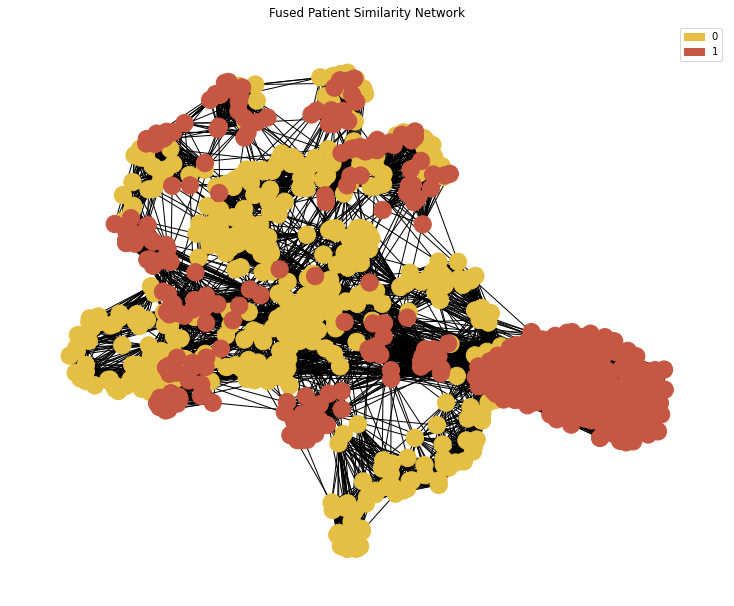

In [7]:
node_colour = phenotypes.loc[adj_snf.index]['Smoking'].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True) # Set node colours

G = plot_knn_network(adj_snf, k , phenotypes['Smoking'] , node_colours=node_colour)  # Plot the fused network and get back networkx graph
plt.title('Fused Patient Similarity Network')
legend_handles = gen_graph_legend(node_colour , G , 'label') # Generate legend
plt.legend(handles = legend_handles)
plt.show()

## <font color='darkblue'> GCN on SNF network </font>

We now have fused our graphs into a single patient similarity network and we are ready to learn from this. 

Again we will re-use the code from the previous part but changing our graph to the the SNF graph created above. 

GCN(
  (gcnlayers): ModuleList(
    (0): GraphConv(in=23676, out=128, normalization=both, activation=None)
    (1): GraphConv(in=128, out=2, normalization=both, activation=None)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout(p=0.05, inplace=False)
)
Graph(num_nodes=1000, num_edges=30268,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int32), 'label': Scheme(shape=(), dtype=torch.int8), 'feat': Scheme(shape=(23676,), dtype=torch.float32)}
      edata_schemes={})


Loss :   0%|          | 0/1200 [00:00<?, ?epoch/s]

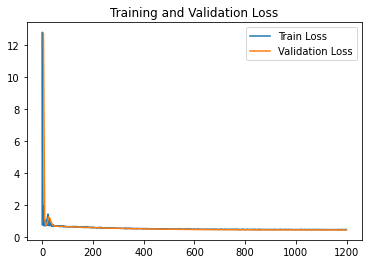

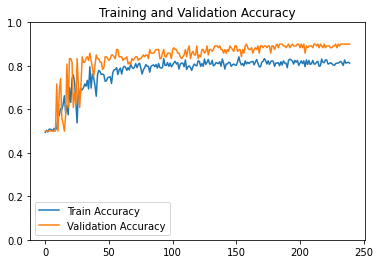

GNN Model | Test Accuracy = 0.8050 | F1 = 0.7746 |


In [8]:
g = dgl.from_networkx(G , node_attrs=['idx' , 'label']) # Convert networkx graph to dgl graph
g.ndata['feat'] = torch.Tensor(loaded_data['Feat'].iloc[g.ndata['idx'].numpy()].values) # Add node features to graph

device = ('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available

g = g.to(device) # Move graph to device

node_subjects = phenotypes['Smoking'].iloc[g.ndata['idx'].detach().cpu().numpy()].reset_index(drop=True) # Get node target labels from meta data
node_subjects.name = 'Smoking'

train_tmp_index , test_index = train_test_split(                # Split data into temporary training and testing sets
    node_subjects.index, train_size=0.6, stratify=node_subjects
    )
train_index , val_index = train_test_split(                     # Split temporary training data into training and validation sets
    train_tmp_index, train_size=0.8, stratify=node_subjects.loc[train_tmp_index]
    )

GCN_input_shapes = g.ndata['feat'].shape[1]  # Get input shape for GCN

labels = F.one_hot(g.ndata['label'].to(torch.int64)) # One hot encode labels

output_metrics = []
logits = np.array([])
labels_all = np.array([])

model = GCN(GCN_input_shapes , [128], len(node_subjects.unique())).to(device)  # Create GCN model
print(model)
print(g)

loss_plot = train(g, g.ndata['feat'] , train_index , val_index , device ,  model , labels , 1200 , 1e-3) # Train model
plt.show()

test_output_metrics = evaluate(test_index , device , g , g.ndata['feat'] , model , labels ) # Evaluate model on test set

print(
    "GNN Model | Test Accuracy = {:.4f} | F1 = {:.4f} |".format(
     test_output_metrics[1] , test_output_metrics[2] )
)